In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from scipy import stats
from statistics import mode

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("hosteria2.csv", sep = ",", encoding = 'latin1', parse_dates=['Fecha'], index_col='Fecha')
df.head(2)

,Reservas
Fecha,
2015-01-12,0
2015-02-12,0


In [3]:
# plt.figure(figsize=(16,4))
# plt.xticks(rotation=90)
# ax = sns.barplot(x=df1.index, y="Reservas", data=df1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1948 entries, 2015-01-12 to 2021-03-31
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Reservas  1948 non-null   int64
dtypes: int64(1)
memory usage: 30.4 KB


In [5]:
df.head()

,Reservas
Fecha,
2015-01-12,0
2015-02-12,0
2015-03-12,0
2015-04-12,11
2015-05-12,24


In [6]:
hosteria = df['Reservas'].resample('MS').mean().to_frame(); 
hosteria.head(2)

,Reservas
Fecha,
2015-01-01,0.0
2015-02-01,0.0


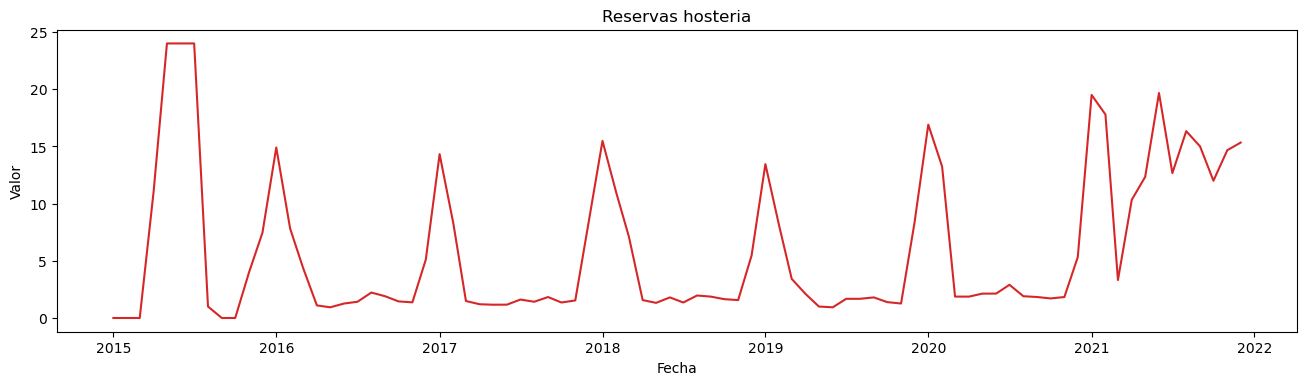

In [7]:
# Función que plotea la serie:
def plot_df(df, x, y, title="", xlabel='Fecha', ylabel='Valor', dpi=100):
    plt.figure(figsize=(16,4), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(hosteria, x=hosteria.index, y=hosteria.Reservas,\
        title='Reservas hosteria')

<Figure size 1152x288 with 0 Axes>

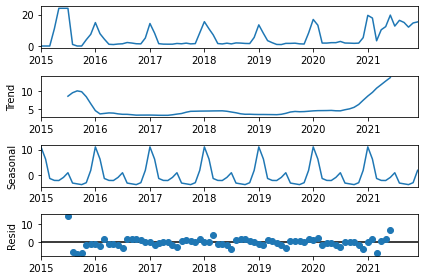

In [8]:
import statsmodels.api as sm
plt.figure(figsize=(16,4))
decomposition = sm.tsa.seasonal_decompose(hosteria, model='additive')
decomposition.plot()
plt.show()

## Predicción series de tiempo

In [9]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

In [10]:
df_ventas = df['Reservas'].resample('MS').mean().to_frame(); df_ventas.head(2)

,Reservas
Fecha,
2015-01-01,0.0
2015-02-01,0.0


<Figure size 288x216 with 0 Axes>

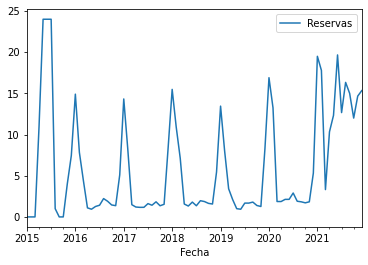

In [11]:
plt.figure(figsize=(4,3)); df_ventas.plot(); plt.show()

In [12]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_ventas, test_size=12, random_state=42, shuffle=False)

In [13]:
df_train.tail(2)

,Reservas
Fecha,
2020-11-01,1.833333
2020-12-01,5.322581


In [14]:
df_train["VentasShift1"] = df_train.Reservas.shift()

# La primera observación nos va a quedar en nan, la reemplazamos por el valor siguente:
df_train["VentasShift1"].fillna(method='bfill', inplace=True)
df_train.head(3)

,Reservas,VentasShift1
Fecha,,
2015-01-01,0.0,0.0
2015-02-01,0.0,0.0
2015-03-01,0.0,0.0


In [15]:
df_test["VentasShift1"] = df_test.Reservas.shift()

df_test["VentasShift1"].fillna(method='bfill', inplace=True)
df_test.head(3)

,Reservas,VentasShift1
Fecha,,
2021-01-01,19.500000,19.500000
2021-02-01,17.789474,19.500000
2021-03-01,3.318182,17.789474


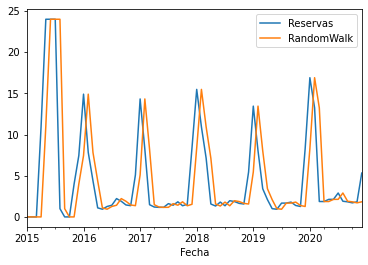

In [16]:
df_train["RandomWalk"] = df_train.VentasShift1
df_train.plot(kind="line", y = ["Reservas", "RandomWalk"]);

In [17]:
df_test["RandomWalk"] = pd.Series(df_train["Reservas"][-1], index=df_test.index)

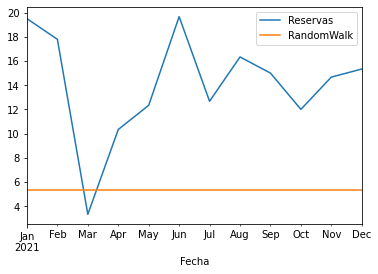

In [18]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
df_test.plot(kind="line", y = ["Reservas", "RandomWalk"]);

In [19]:
# Calculamos el RMSE y almacenamos los resultados
df_Results = pd.DataFrame(columns = ["Model", "RMSE"])
df_Results.loc[0, "Model"] = "Random Walk"
df_Results.loc[0, "RMSE"] = RMSE(df_test.RandomWalk, df_test.Reservas)
df_Results

,Model,RMSE
0,Random Walk,9.75274


In [20]:
model_mean_pred = df_train['Reservas'].mean()
model_mean_pred

4.636002230579539

In [21]:
df_train_mc = df_train.copy()
df_train_mc['Mean'] = model_mean_pred

df_test_mc = df_test.copy()
df_test_mc['Mean'] = model_mean_pred

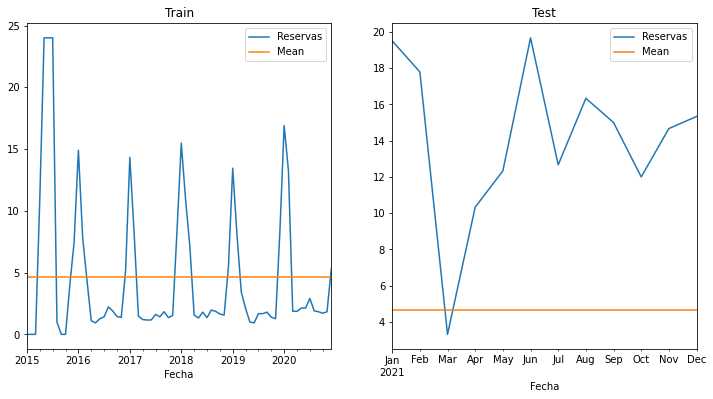

In [22]:
fig, axes = plt.subplots(1, 2,figsize=(12,6))
df_train_mc.plot(ax=axes[0], y = ["Reservas","Mean"],title='Train')
df_test_mc.plot(ax=axes[1],y = ["Reservas","Mean"], title='Test')
plt.show()

In [23]:
model_RMSE = RMSE(df_test_mc.Mean, df_test_mc.Reservas)
df_Results.loc[1, "Model"] = "Mean"
df_Results.loc[1, "RMSE"] = model_RMSE
df_Results.head()

,Model,RMSE
0,Random Walk,9.75274
1,Mean,10.3735


In [24]:
df_ventas["timeIndex"] = pd.Series(np.arange(len(df_ventas['Reservas'])), index=df_ventas.index)
df_ventas.timeIndex.head(3)

Fecha
2015-01-01    0
2015-02-01    1
2015-03-01    2
Freq: MS, Name: timeIndex, dtype: int32

In [25]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_ventas, test_size=12, random_state=42, shuffle=False)

In [26]:
import statsmodels.api as sm
sm.OLS.from_formula

<bound method Model.from_formula of <class 'statsmodels.regression.linear_model.OLS'>>

In [27]:
import statsmodels.formula.api as smf
model_linear = smf.ols(formula='Reservas ~ timeIndex', data = df_train).fit()

In [28]:
df_train["LinearTrend"] = model_linear.predict(df_train.timeIndex)
df_test["LinearTrend"] = model_linear.predict(df_test.timeIndex)

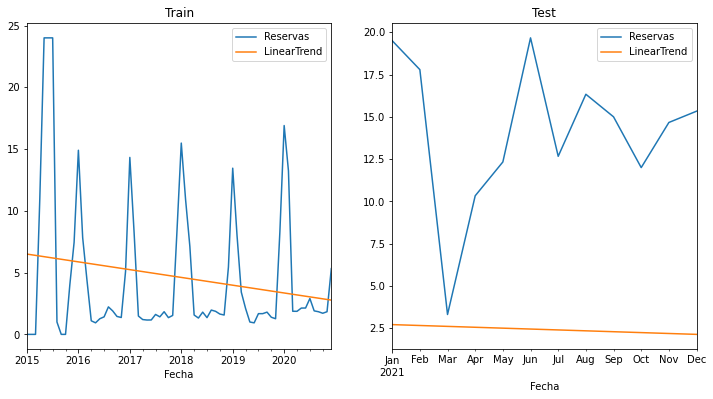

In [29]:
fig, axes = plt.subplots(1, 2,figsize=(12,6))
df_train.plot(kind = "line", y = ["Reservas","LinearTrend"],ax=axes[0],title='Train');
df_test.plot(kind = "line", y = ["Reservas","LinearTrend"],ax=axes[1],title='Test');
plt.show()

In [30]:
model_RMSE = RMSE(df_test.LinearTrend, df_test.Reservas)

In [31]:
df_Results.loc[2, "Model"] = "LinearTrend"
df_Results.loc[2, "RMSE"] = model_RMSE
df_Results.head()

,Model,RMSE
0,Random Walk,9.75274
1,Mean,10.3735
2,LinearTrend,12.4174


In [32]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Reservas   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     2.573
Date:                Sun, 07 Nov 2021   Prob (F-statistic):              0.113
Time:                        18:17:47   Log-Likelihood:                -227.33
No. Observations:                  72   AIC:                             458.7
Df Residuals:                      70   BIC:                             463.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.4990      1.346      4.829      0.000       3.815       9.183
timeIndex     -0.0525      0.033     -1.604      0.113      -0.118       0.013
==============================================================================
Omnibus:                       29.779   Durbin-Watson:                   0.746
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.881
Skew:                           1.659   Prob(JB):                     4.01e-11
Kurtosis:                       5.226   Cond. No.                         81.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
df_ventas["timeIndex_sq"] = df_ventas["timeIndex"]**2
df_ventas.timeIndex_sq.head(3)

Fecha
2015-01-01    0
2015-02-01    1
2015-03-01    4
Freq: MS, Name: timeIndex_sq, dtype: int32

In [34]:
df_ventas.head(5)

,Reservas,timeIndex,timeIndex_sq
Fecha,,,
2015-01-01,0.0,0,0
2015-02-01,0.0,1,1
2015-03-01,0.0,2,4
2015-04-01,11.0,3,9
2015-05-01,24.0,4,16


In [35]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_ventas, test_size=12, random_state=42, shuffle=False)

In [36]:
import statsmodels.formula.api as smf
model_quadratic = smf.ols('Reservas ~ timeIndex + timeIndex_sq', data = df_train).fit()

In [37]:
df_train["QuadraticTrend"] = model_quadratic.predict(df_train[["timeIndex","timeIndex_sq"]])
df_test["QuadraticTrend"] = model_quadratic.predict(df_test[["timeIndex","timeIndex_sq"]])

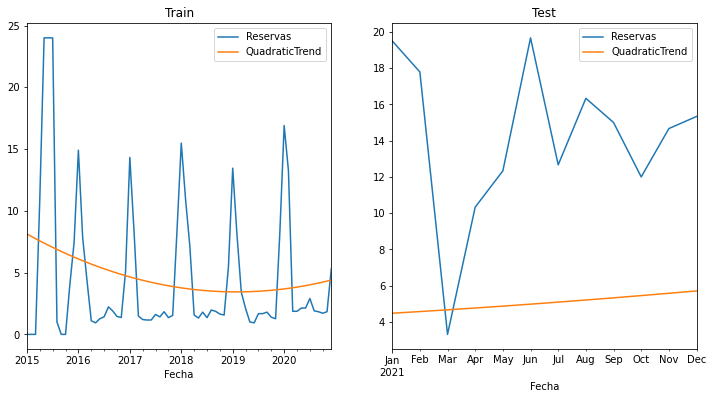

In [38]:
fig, axes = plt.subplots(1, 2,figsize=(12,6))
df_train.plot(kind = "line", y = ["Reservas","QuadraticTrend"],ax=axes[0],title='Train');
df_test.plot(kind = "line", y = ["Reservas","QuadraticTrend"],ax=axes[1],title='Test');
plt.show()

In [39]:
model_RMSE = RMSE(df_test.QuadraticTrend, df_test.Reservas)
df_Results.loc[3, "Model"] = "QuadraticTrend"
df_Results.loc[3, "RMSE"] = model_RMSE
df_Results.head()

,Model,RMSE
0,Random Walk,9.75274
1,Mean,10.3735
2,LinearTrend,12.4174
3,QuadraticTrend,9.98471


In [40]:
model_quadratic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Reservas   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     1.911
Date:                Sun, 07 Nov 2021   Prob (F-statistic):              0.156
Time:                        18:17:48   Log-Likelihood:                -226.69
No. Observations:                  72   AIC:                             459.4
Df Residuals:                      69   BIC:                             466.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        8.1208      1.981      4.099      0.000       4.169      12.073
timeIndex       -0.1915      0.129     -1.485      0.142      -0.449       0.066
timeIndex_sq     0.0020      0.002      1.114      0.269      -0.002       0.005
==============================================================================
Omnibus:                       25.073   Durbin-Watson:                   0.760
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.702
Skew:                           1.488   Prob(JB):                     1.77e-08
Kurtosis:                       4.744   Cond. No.                     6.66e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
df_train['log_Ventas'] = np.log(df_train['Reservas'])
df_test['log_Ventas'] = np.log(df_test['Reservas'])

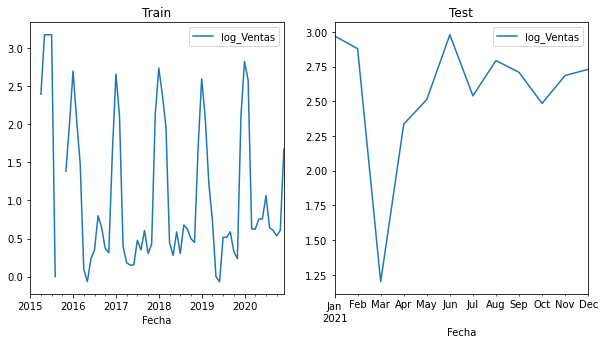

In [42]:
fig, axes = plt.subplots(1, 2,figsize=(10,5))
df_train.plot(kind = "line", y = ["log_Ventas"],ax=axes[0],title='Train');
df_test.plot(kind = "line", y = ["log_Ventas"],ax=axes[1],title='Test');
plt.show()

In [43]:
import statsmodels.formula.api as smf
model_log = smf.ols('log_Ventas ~ timeIndex', data = df_train).fit()

In [44]:
# # Dividimos en train y test
# from sklearn.model_selection import train_test_split
# df_train, df_test = train_test_split(df, test_size=12, random_state=42, shuffle=False)

In [45]:
# model_log_est = smf.ols( \
#     'log_Ventas ~ timeIndex + Aug + Dec + Feb + Jan + Jul + Jun + Mar + May + Nov + Oct + Sep', \
#     data = df_train).fit()


In [46]:
df_train.head()

,Reservas,timeIndex,timeIndex_sq,QuadraticTrend,log_Ventas
Fecha,,,,,
2015-01-01,0.0,0,0,8.120809,-inf
2015-02-01,0.0,1,1,7.931277,-inf
2015-03-01,0.0,2,4,7.745661,-inf
2015-04-01,11.0,3,9,7.563961,2.397895
2015-05-01,24.0,4,16,7.386176,3.178054


# NULOSS

In [47]:
df_train["LogTrend"] = model_log.predict(df_train[["timeIndex"]])
df_test["LogTrend"] = model_log.predict(df_test[["timeIndex"]])

In [48]:
df_test.head()

,Reservas,timeIndex,timeIndex_sq,QuadraticTrend,log_Ventas,LogTrend
Fecha,,,,,,
2021-01-01,19.500000,72,5184,4.483261,2.970414,NaN
2021-02-01,17.789474,73,5329,4.575666,2.878607,NaN
2021-03-01,3.318182,74,5476,4.671986,1.199417,NaN
2021-04-01,10.333333,75,5625,4.772222,2.335375,NaN
2021-05-01,12.333333,76,5776,4.876375,2.512306,NaN


In [49]:
df_train['back_LogTrend'] = np.exp(df_train['LogTrend'])
df_test['back_LogTrend'] = np.exp(df_test['LogTrend'])

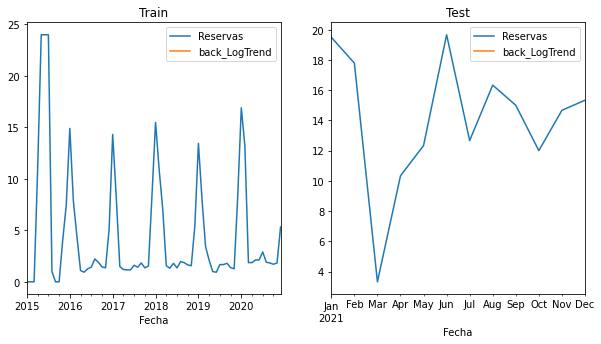

In [50]:
fig, axes = plt.subplots(1, 2,figsize=(10,5))
df_train.plot(kind = "line", y = ["Reservas","back_LogTrend"],ax=axes[0],title='Train');
df_test.plot(kind = "line", y = ["Reservas","back_LogTrend"],ax=axes[1],title='Test');
plt.show()

In [51]:
model_RMSE = RMSE(df_test.back_LogTrend, df_test.Reservas)
df_Results.loc[4, "Model"] = "back_LogTrend"
df_Results.loc[4, "RMSE"] = model_RMSE
df_Results.head()

,Model,RMSE
0,Random Walk,9.75274
1,Mean,10.3735
2,LinearTrend,12.4174
3,QuadraticTrend,9.98471
4,back_LogTrend,NaN


In [52]:
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_Ventas   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 07 Nov 2021   Prob (F-statistic):                nan
Time:                        18:17:48   Log-Likelihood:                    nan
No. Observations:                  72   AIC:                               nan
Df Residuals:                      70   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept        -inf        nan        nan        nan         nan         nan
timeIndex         inf        nan        nan        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                     nan
Prob(Omnibus):                    nan   Jarque-Bera (JB):                  nan
Skew:                             nan   Prob(JB):                          nan
Kurtosis:                         nan   Cond. No.                         81.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
# Creamos columna con el mes
df_train['month'] = [d.strftime('%b') for d in df_train.index]
df_test['month']  = [d.strftime('%b') for d in df_test.index]

In [54]:
# Creamos las variables dummies de mes
dummies_mes_train = pd.get_dummies(df_train['month'])
dummies_mes_test = pd.get_dummies(df_test['month'])

In [55]:
# Hacemos el join entre el DataFrame con la serie de tiempo y las dummies
df_train = df_train.join(dummies_mes_train)
df_test = df_test.join(dummies_mes_test)
df_train.head(4)

,Reservas,timeIndex,timeIndex_sq,QuadraticTrend,log_Ventas,LogTrend,back_LogTrend,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
Fecha,,,,,,,,,,,,,,,,,,,,
2015-01-01,0.0,0,0,8.120809,-inf,NaN,NaN,Jan,0,0,0,0,1,0,0,0,0,0,0,0
2015-02-01,0.0,1,1,7.931277,-inf,NaN,NaN,Feb,0,0,0,1,0,0,0,0,0,0,0,0
2015-03-01,0.0,2,4,7.745661,-inf,NaN,NaN,Mar,0,0,0,0,0,0,0,1,0,0,0,0
2015-04-01,11.0,3,9,7.563961,2.397895,NaN,NaN,Apr,1,0,0,0,0,0,0,0,0,0,0,0


In [56]:
df_train.columns

Index(['Reservas', 'timeIndex', 'timeIndex_sq', 'QuadraticTrend', 'log_Ventas',
       'LogTrend', 'back_LogTrend', 'month', 'Apr', 'Aug', 'Dec', 'Feb', 'Jan',
       'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep'],
      dtype='object')

In [57]:
model_log_est = smf.ols('log_Ventas ~ timeIndex + Apr + Aug + Dec + Feb + Jan + Jul + Jun + Mar + May + Nov + Oct + Sep',data = df_train).fit()

In [58]:
df_train['model_log_est'] = model_log_est.predict(df_train[["timeIndex",'Apr', 'Aug', 'Dec', 'Feb', 'Jan','Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep']])
df_test['model_log_est'] = model_log_est.predict(df_test[["timeIndex",'Apr', 'Aug', 'Dec', 'Feb', 'Jan','Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep']])

In [59]:
df_train['back_LogEstTrend'] = np.exp(df_train['model_log_est'])
df_test['back_LogEstTrend'] = np.exp(df_test['model_log_est'])

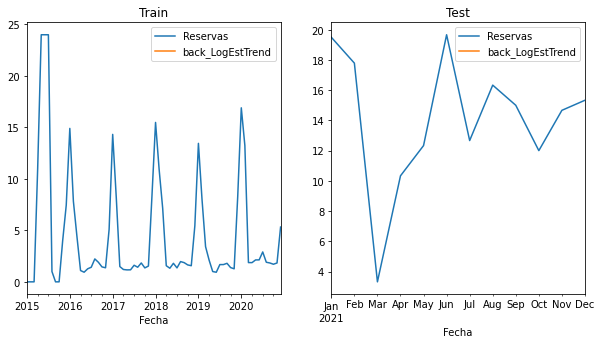

In [60]:
fig, axes = plt.subplots(1, 2,figsize=(10,5))
df_train.plot(kind = "line", y = ["Reservas","back_LogEstTrend"],ax=axes[0],title='Train');
df_test.plot(kind = "line", y = ["Reservas","back_LogEstTrend"],ax=axes[1],title='Test');
plt.show()

In [61]:
model_RMSE = RMSE(df_test.back_LogEstTrend, df_test.Reservas)
df_Results.loc[5, "Model"] = "back_LogEstTrend"
df_Results.loc[5, "RMSE"] = model_RMSE
df_Results.head()

,Model,RMSE
0,Random Walk,9.75274
1,Mean,10.3735
2,LinearTrend,12.4174
3,QuadraticTrend,9.98471
4,back_LogTrend,NaN


In [62]:
model_log_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_Ventas   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 07 Nov 2021   Prob (F-statistic):                nan
Time:                        18:17:49   Log-Likelihood:                    nan
No. Observations:                  72   AIC:                               nan
Df Residuals:                      59   BIC:                               nan
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept        -inf        nan        nan        nan         nan         nan
timeIndex         inf        nan        nan        nan         nan         nan
Apr               inf        nan        nan        nan         nan         nan
Aug               inf        nan        nan        nan         nan         nan
Dec               inf        nan        nan        nan         nan         nan
Feb               nan        nan        nan        nan         nan         nan
Jan               nan        nan        nan        nan         nan         nan
Jul               inf        nan        nan        nan         nan         nan
Jun               inf        nan        nan        nan         nan         nan
Mar               nan        nan        nan        nan         nan         nan
May               inf        nan        nan        nan         nan         nan
Nov               inf        nan        nan        nan         nan         nan
Oct               nan        nan        nan        nan         nan         nan
Sep               nan        nan        nan        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                     nan
Prob(Omnibus):                    nan   Jarque-Bera (JB):                  nan
Skew:                             nan   Prob(JB):                          nan
Kurtosis:                         nan   Cond. No.                     6.16e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.21e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [63]:
df_ventas["sma_5"] = df_ventas.Reservas.rolling(5,min_periods=1).mean()
df_ventas["sma_15"] = df_ventas.Reservas.rolling(15,min_periods=1).mean()

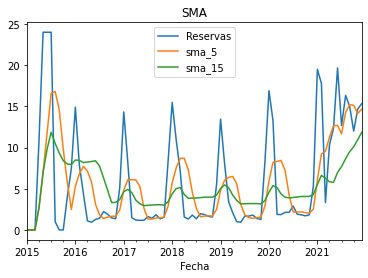

In [64]:
df_ventas.plot(kind = "line", y = ["Reservas","sma_5","sma_15"],title='SMA');

In [65]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model_exp_smoothing_3 = SimpleExpSmoothing(df_train.Reservas).fit(smoothing_level=0.3,optimized=False)
model_exp_smoothing_5 = SimpleExpSmoothing(df_train.Reservas).fit(smoothing_level=0.5,optimized=False)
model_exp_smoothing_8 = SimpleExpSmoothing(df_train.Reservas).fit(smoothing_level=0.8,optimized=False)

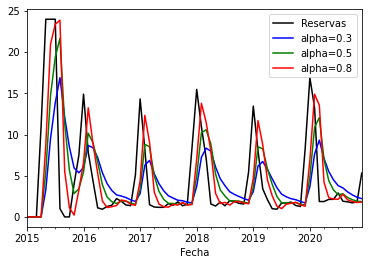

In [66]:
df_train.plot(kind = "line", y = "Reservas",color='black')
model_exp_smoothing_3.fittedvalues.plot(label="alpha=0.3",color='b');
model_exp_smoothing_5.fittedvalues.plot(label="alpha=0.5",color='g');
model_exp_smoothing_8.fittedvalues.plot(label="alpha=0.8",color='r');
plt.legend();

In [67]:
df_test["Simple_Smoothing_3"] = model_exp_smoothing_3.forecast(len(df_test))
df_test["Simple_Smoothing_5"] = model_exp_smoothing_5.forecast(len(df_test))
df_test["Simple_Smoothing_8"] = model_exp_smoothing_8.forecast(len(df_test))

In [68]:
model_RMSE_3 = RMSE(df_test["Simple_Smoothing_3"], df_test.Reservas)
model_RMSE_5 = RMSE(df_test["Simple_Smoothing_5"], df_test.Reservas)
model_RMSE_8 = RMSE(df_test["Simple_Smoothing_8"], df_test.Reservas)

In [69]:
# Calculamos el RMSE y almacenamos los resultados
df_Results.loc[6, "Model"] = "Simple Smoothing a=0.3"; df_Results.loc[6, "RMSE"] = model_RMSE_3
df_Results.loc[7, "Model"] = "Simple Smoothing a=0.5"; df_Results.loc[7, "RMSE"] = model_RMSE_5
df_Results.loc[8, "Model"] = "Simple Smoothing a=0.8"; df_Results.loc[8, "RMSE"] = model_RMSE_8
df_Results

,Model,RMSE
0,Random Walk,9.75274
1,Mean,10.3735
2,LinearTrend,12.4174
3,QuadraticTrend,9.98471
4,back_LogTrend,NaN
5,back_LogEstTrend,NaN
6,Simple Smoothing a=0.3,11.741
7,Simple Smoothing a=0.5,11.3293
8,Simple Smoothing a=0.8,10.3871


## Series de tiempo 2

In [70]:
df["timeIndex"] = pd.Series(np.arange(len(df['Reservas'])), index=df.index)
df['log_value'] = np.log(df['Reservas'])
df['month'] = [d.strftime('%b') for d in df.index]
dummies_mes = pd.get_dummies(df['month'])
df = df.join(dummies_mes)

In [71]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=12, random_state=42, shuffle=False)

In [72]:
model_log_est = smf.ols('log_value ~ timeIndex + Aug + Dec + Feb + Jan + Jul + Jun + Mar + May + Nov + Oct + Sep',data = df_train).fit()

In [73]:
df_train['model_log_est'] = model_log_est.predict(
    df_train[["timeIndex", "Aug", "Dec", "Feb", "Jan", "Jul", "Jun", "Mar", "May", "Nov", "Oct", "Sep"]])
df_test['model_log_est'] = model_log_est.predict(  
    df_test[["timeIndex", "Aug", "Dec", "Feb", "Jan","Jul", "Jun", "Mar", "May", "Nov", "Oct", "Sep"]])

In [74]:
df_train['back_model_log_est'] = np.exp(df_train['model_log_est'])
df_test['back_model_log_est'] = np.exp(df_test['model_log_est'])

In [75]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse
df_Results = pd.DataFrame(columns = ["Model", "RMSE"])
df_Results.loc[0, "Model"] = "Log Model + est"
df_Results.loc[0, "RMSE"] = RMSE(df_test['back_model_log_est'], df_test['Reservas'])
df_Results

,Model,RMSE
0,Log Model + est,NaN


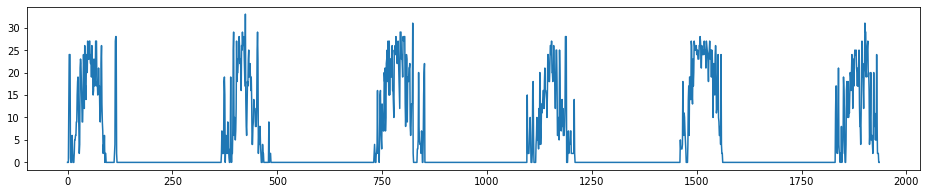

In [76]:
plt.figure(figsize=(16,3)); plt.plot(df_train.timeIndex, df_train.Reservas); plt.show()

In [77]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_train['Reservas']); 
print('ADF Statistic: %f' % result[0]); print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -4.381423
p-value: 0.000320
Valor crítico 1%: -3.43
Valor crítico 5%: -2.86
Valor crítico 10%: -2.57


In [78]:
df_train

,Reservas,timeIndex,log_value,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,model_log_est,back_model_log_est
Fecha,,,,,,,,,,,,,,,,,,
2015-01-12,0,0,-inf,Jan,0,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN
2015-02-12,0,1,-inf,Feb,0,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN
2015-03-12,0,2,-inf,Mar,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN
2015-04-12,11,3,2.397895,Apr,1,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN
2015-05-12,24,4,3.178054,May,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-15,2,1931,0.693147,Mar,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN
2021-03-16,2,1932,0.693147,Mar,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN
2021-03-17,2,1933,0.693147,Mar,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN


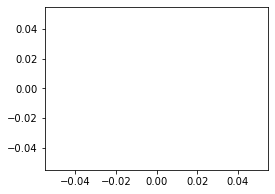

In [79]:
res_model = df_train['Reservas'] - df_train['back_model_log_est']
plt.figure(figsize=(4,3)); plt.plot(df_train.timeIndex, res_model, '-');plt.show()

## ARIMA

In [81]:
# Importamos el modelo ARIMA de statsmodels
from statsmodels.tsa.arima_model import ARIMA

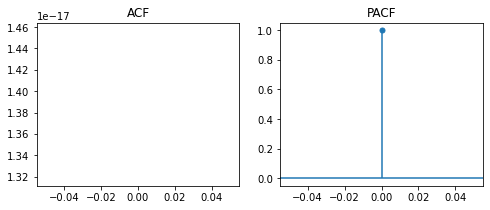

In [82]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(1, 2,figsize=(8,3))
smt.graphics.plot_acf(res_model, lags=20,ax=axes[0],title='ACF')
smt.graphics.plot_pacf(res_model, lags=20,ax=axes[1],title='PACF')
plt.show()

In [100]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df.Reservas, order=(1,1,2))
results_ARIMA = model.fit(disp=0)
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.Reservas   No. Observations:                 1947
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -5175.472
Method:                       css-mle   S.D. of innovations              3.453
Date:                Sun, 07 Nov 2021   AIC                          10360.944
Time:                        18:25:52   BIC                          10388.814
Sample:                             1   HQIC                         10371.191
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0021      0.025     -0.085      0.933      -0.052       0.048
ar.L1.D.Reservas     0.3493      0.049      7.092      0.000       0.253       0.446
ma.L1.D.Reservas    -0.6502 

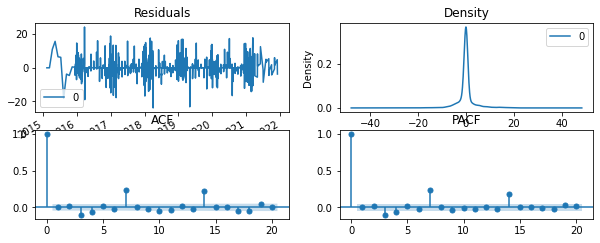

In [101]:
residuals = pd.DataFrame(results_ARIMA.resid)
fig, axes = plt.subplots(2, 2,figsize=(10,4))

residuals.plot(title="Residuals", ax=axes[0,0]); 
residuals.plot(kind='kde', title='Density', ax=axes[0,1])
smt.graphics.plot_acf(residuals, lags=20,ax=axes[1,0],title='ACF'); 
smt.graphics.plot_pacf(residuals, lags=20,ax=axes[1,1],title='PACF')
plt.show()

In [104]:
predictions_ARIMA, se, conf = results_ARIMA.forecast(len(df_test['Reservas']), alpha=0.05)

In [105]:
df_train['model_ARIMA'] = df_train['Reservas'] + results_ARIMA.fittedvalues
df_test['model_ARIMA'] = df_test['Reservas'] + predictions_ARIMA

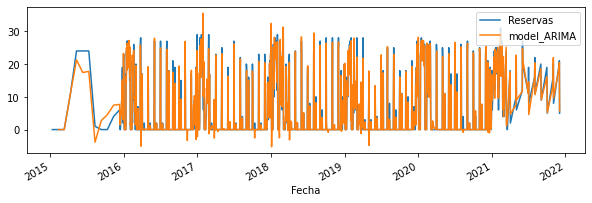

In [107]:
df_train.plot(kind = "line", y = ['Reservas', 'model_ARIMA'],figsize=(10,3));

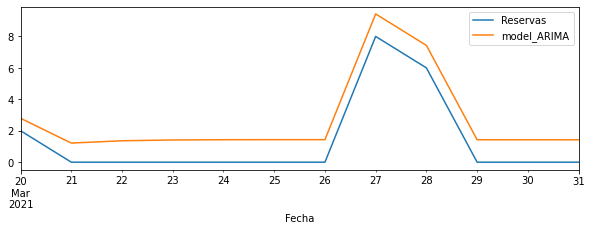

In [108]:
df_test.plot(kind = "line", y = ['Reservas', 'model_ARIMA'],figsize=(10,3));

In [110]:
df_Results.loc[1, "Model"] = "Log Model + est + ARIMA"
df_Results.loc[1, "RMSE"] = RMSE(df_test['model_ARIMA'], df_test['Reservas'])
df_Results

,Model,RMSE
0,Log Model + est,NaN
1,Log Model + est + ARIMA,1.36349
